#### Import libraries

In [525]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_venn import venn2, venn2_circles
import requests
import july 
from july.utils import date_range
from datetime import datetime
import squarify

plt.style.use('ggplot')

#### Colormap (https://github.com/e-hulten/july/blob/master/src/july/colormaps.py)

In [516]:
def tups2cmap(tups_list, reverse=False):
    
    cmap = [list(tup) for tup in tups_list]
    cmap = [[x / 255 for x in lst] for lst in cmap]
    
    return cmap if not reverse else cmap[::-1]

cmaps_list = plt.colormaps()
cmaps_dict = dict(zip(cmaps_list, cmaps_list))

july_lst = [
    (204, 71, 71, 255),
    (230, 97, 97, 255),
    (255, 122, 122, 255),
    (255, 141, 130, 255),
    (255, 161, 138, 255),
    (254, 187, 152, 255),
    (252, 204, 162, 255),
    (249, 217, 174, 255),
    (246, 232, 182, 255),
    (245, 238, 186, 255),
    (255, 255, 212, 255),
    (255, 255, 237, 255),
]
cmaps_dict['july'] = LinearSegmentedColormap.from_list('', tups2cmap(july_lst, True))

#### Functions

In [601]:
def create_most_watched(df, merged_df, trakt_user):
    
    # Most watched shows
    mws = df.groupby(['trakt_user', 'show'])['title'].count().reset_index().sort_values(
        'title', ascending=False).reset_index(drop=True)
    mws = mws[mws['trakt_user'] == trakt_user].head(10).sort_values('title')
    
    # Most watched networks
    mwn = merged_df[merged_df['trakt_user'] == trakt_user]
    mwn = mwn[['show', 'network']].drop_duplicates().reset_index(drop=True)
    mwn = mwn.value_counts('network').reset_index().rename(columns={0: 'count'})
    
    return mws, mwn

def visualize_mws_mwn(mws, mwn, cmaps_dict):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'facecolor': '#F7F7F7'})
    _ = mws.plot(kind='barh', width=0.9, color='#C94646', alpha=0.6, legend=False, ax=ax1)
    for i, (p, pr) in enumerate(zip(mws['show'], mws['title'])):
        _ = ax1.text(s=p, x=1, y=i, color='black', verticalalignment='center', size=12)
        _ = ax1.text(s=str(pr), x=pr-1, y=i, color='black', verticalalignment='center', horizontalalignment='center', size=12)
    _ = ax1.axis('off')
    norm = mpl.colors.Normalize(vmin=min(mwn['count']), vmax=max(mwn['count']))
    colors = [cmaps_dict['july'](norm(value)) for value in mwn['count']]
    _ = squarify.plot(sizes=mwn['count'], label=['Comedy\nCentral' if x == 'Comedy Central' else x for x in mwn['network']], 
                      alpha=0.6, color=colors, ax=ax2)
    _ = ax2.axis('off')

def create_venn_diagram(df, ax, users=['szigony', 'moana'], colors=['#C94646', '#FAEDD1']):
    
    a_shows = list(set(df[df['trakt_user'] == users[0]]['show']))
    b_shows = list(set(df[df['trakt_user'] == users[1]]['show']))
    x_shows = set(a_shows).intersection(b_shows)
    subsets = (len(a_shows)-len(x_shows), len(x_shows), len(b_shows)-len(x_shows))
    
    venn2(
        subsets = subsets,
        set_labels = (users[0], users[1]),
        set_colors = (colors[0], colors[1]),
        alpha = 0.6,
        ax = ax
    )
    venn2_circles(
        subsets = subsets,
        linewidth = 1,
        color = 'gray',
        ax = ax
    )

def create_radar_chart_data(df, users=['szigony', 'moana'], 
                            genres=['comedy', 'drama', 'science-fiction', 'fantasy', 'reality', 'animation']):
    
    a_shows = list(set(df[df['trakt_user'] == users[0]]['show']))
    b_shows = list(set(df[df['trakt_user'] == users[1]]['show']))
    x_shows = set(a_shows).intersection(b_shows)
    
    df_filtered = df[df['genres'].isin(genres)]
    df_x = df_filtered[df_filtered['show'].isin(list(x_shows))]
    df_a = df_filtered[df_filtered['show'].isin(set(a_shows) - x_shows)]
    df_b = df_filtered[df_filtered['show'].isin(set(b_shows) - x_shows)]
    
    count_x = df_x.value_counts('genres').reset_index().rename(columns={0: 'x_count'})
    count_a = df_a.value_counts('genres').reset_index().rename(columns={0: 'a_count'})
    count_b = df_b.value_counts('genres').reset_index().rename(columns={0: 'b_count'})
    count_df = count_x.merge(count_a, how='left', on='genres').merge(count_b, how='left', on='genres').fillna(0)
    count_df['genres'] = ['sci-fi' if x == 'science-fiction' else x for x in count_df['genres']]
    
    x_total = np.sum(count_df['x_count'])
    a_total = np.sum(count_df['a_count'])
    b_total = np.sum(count_df['b_count'])
    
    count_df['x_count'] = [(x/x_total)*100 for x in count_df['x_count']]
    count_df['a_count'] = [(x/a_total)*100 for x in count_df['a_count']]
    count_df['b_count'] = [(x/b_total)*100 for x in count_df['b_count']]
    
    return count_df

def create_radar_chart(df, colors=['#C94646', '#FAEDD1'], labels=['szigony', 'moana']):
    
    angles = np.linspace(0, 2*np.pi, len(df), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    
    list_genres = ['comedy', 'drama', 'fantasy', 'sci-fi', 'animation', 'reality']
    list_genres.append(list_genres[0])
    # list_x = df['x_count'].tolist()
    # list_x.append(list_x[0])
    list_a = df['a_count'].tolist()
    list_a.append(list_a[0])
    list_b = df['b_count'].tolist()
    list_b.append(list_b[0])
    
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'projection': 'polar', 'facecolor': '#F7F7F7'})
    _ = ax.plot(angles, list_a, color=colors[0], label=labels[0])
    _ = ax.fill(angles, list_a, alpha=0.6, color=colors[0])
    _ = ax.plot(angles, list_b, color=colors[1], label=labels[1])
    _ = ax.fill(angles, list_b, alpha=0.6, color=colors[1])
    _ = ax.set_thetagrids(angles*180/np.pi, list_genres)
    _ = ax.set_rticks(np.arange(0, np.max(list_a + list_b), 10))
    _ = ax.set_rlabel_position(26.5)
    _ = ax.xaxis.set_tick_params(pad=20)
    _ = plt.legend(loc='best', bbox_to_anchor=(1.3, 0.2))

#### Load data `csv`s, create merged and pre/post-marriage DataFrames

In [591]:
df = pd.read_csv('data/watch_history.csv', parse_dates=['watched_at'])
info_df = pd.read_csv('data/genres_and_networks.csv')

marriage_date = pd.Timestamp(2021, 9, 4)
df_post = df[df['watched_at'] >= marriage_date]
df_pre = df[df['watched_at'] < marriage_date]

merged_df = df.merge(info_df, how='inner', on='imdb_id') # genre_df
merged_pre = df_pre.merge(info_df, how='inner', on='imdb_id') # genre_pre
merged_post = df_post.merge(info_df, how='inner', on='imdb_id') # genre_post

#### Visualizations
* Most watched shows and networks

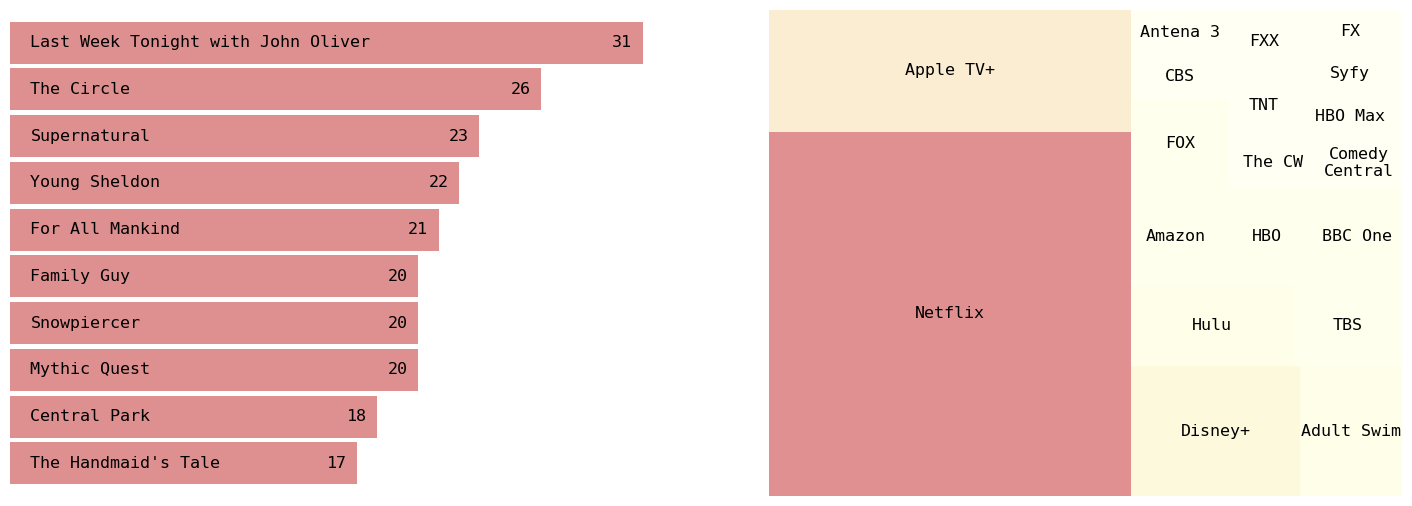

In [614]:
mws, mwn = create_most_watched(df, merged_df, 'szigony')
visualize_mws_mwn(mws, mwn, cmaps_dict)

* Heatmap based on date (https://github.com/e-hulten/july)

<AxesSubplot:>

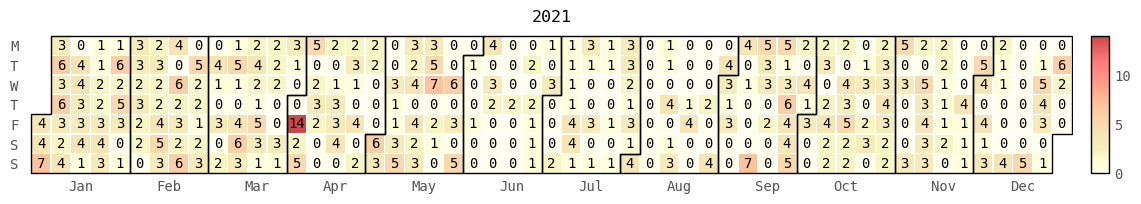

In [527]:
start_at = '2021-01-01'
end_at = '2021-12-31'
idx = pd.date_range(start_at, end_at)
watched_by_date = df[df['trakt_user'] == 'szigony'].groupby(['watched_at'])['title'].count().reset_index()
watched_by_date.set_index('watched_at', inplace=True)
watched_by_date = watched_by_date.reindex(idx, fill_value=0)

july.heatmap(
    dates=date_range(start_at, end_at), 
    data=watched_by_date['title'], 
    value_label=True,
    colorbar=True,
    fontfamily='monospace',
    fontsize=10,
    month_grid=True
)

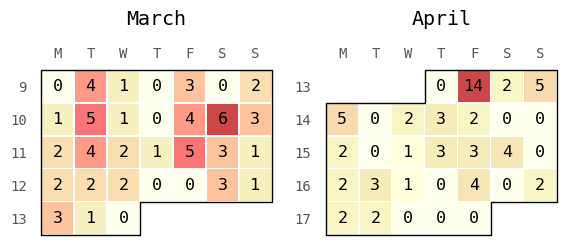

In [528]:
fig, (ax1, ax2) = plt.subplots(1, 2)
_ = july.month_plot(dates=date_range(start_at, end_at), data=watched_by_date['title'], month=3, value_label=True, ax=ax1)
_ = july.month_plot(dates=date_range(start_at, end_at), data=watched_by_date['title'], month=4, value_label=True, ax=ax2)

In [206]:
df[(df['watched_at'].astype(str) == '2021-04-02') & (df['trakt_user'] == 'szigony')] # it was a Friday, so who knows

,trakt_id,watched_at,season,episode,title,show,imdb_id,trakt_user
442,7387203866,2021-04-02,For All Mankind,2,6,Best-Laid Plans,tt7772588,szigony
443,7387082035,2021-04-02,Supernatural,12,23,All Along the Watchtower,tt0460681,szigony
444,7387081842,2021-04-02,Supernatural,12,22,Who We Are,tt0460681,szigony
445,7386959924,2021-04-02,Solar Opposites,2,3,The Lake House Device,tt8910922,szigony
446,7386959885,2021-04-02,Solar Opposites,2,2,The Earth Eraser,tt8910922,szigony
447,7386283842,2021-04-02,Snowpiercer,2,10,Into the White,tt6156584,szigony
448,7386283729,2021-04-02,Snowpiercer,2,9,The Show Must Go On,tt6156584,szigony
449,7386081390,2021-04-02,Nailed It!,5,6,Can't Believe It's Cake!,tt6987788,szigony
450,7386081364,2021-04-02,Nailed It!,5,5,I've Failed and I Can't Get Up!,tt6987788,szigony
451,7386081345,2021-04-02,Nailed It!,5,4,Travel Dos and Donuts,tt6987788,szigony


In [215]:
wo_watching = len(watched_by_date[watched_by_date['title'] == 0])
print('Days without watching: ' + str(wo_watching))
print('Days with watching: ' + str(len(watched_by_date) - wo_watching))

Days without watching: 121
Days with watching: 244


* Venn-diagram

https://towardsdatascience.com/how-to-create-and-customize-venn-diagrams-in-python-263555527305

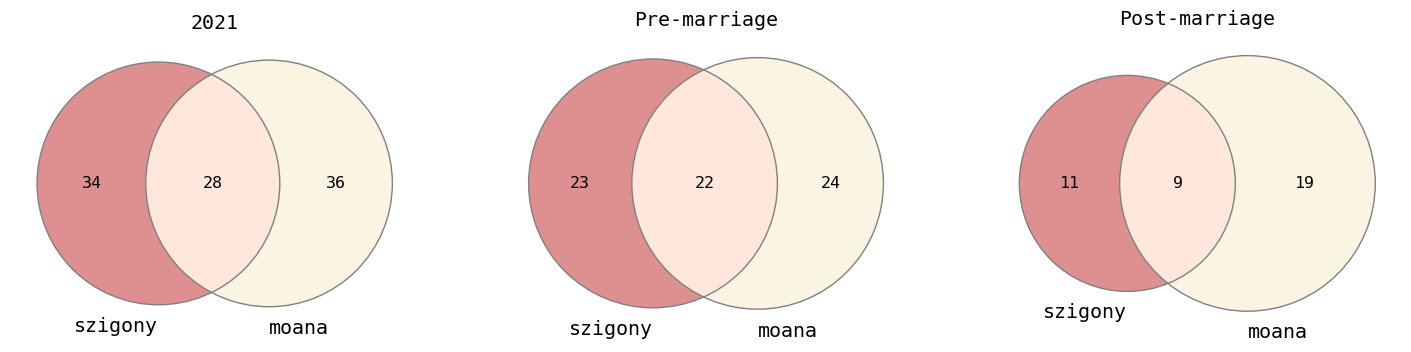

In [608]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
_ = create_venn_diagram(df, ax1)
_ = ax1.set_title('2021', pad=1)
_ = create_venn_diagram(df_pre, ax2)
_ = ax2.set_title('Pre-marriage', pad=1)
_ = create_venn_diagram(df_post, ax3)
_ = ax3.set_title('Post-marriage', pad=1)

__TODO:__ 100% stacked bar chart pre/post-marriage, csak egy számosság, hány epizódot néztünk

* Radar chart

https://towardsdatascience.com/how-to-create-a-radar-chart-in-python-36b9ebaa7a64

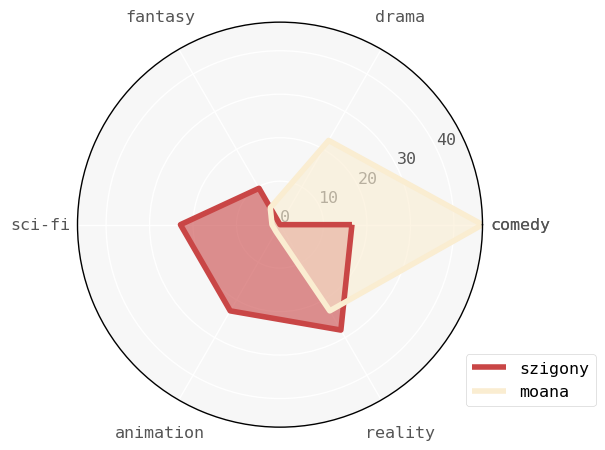

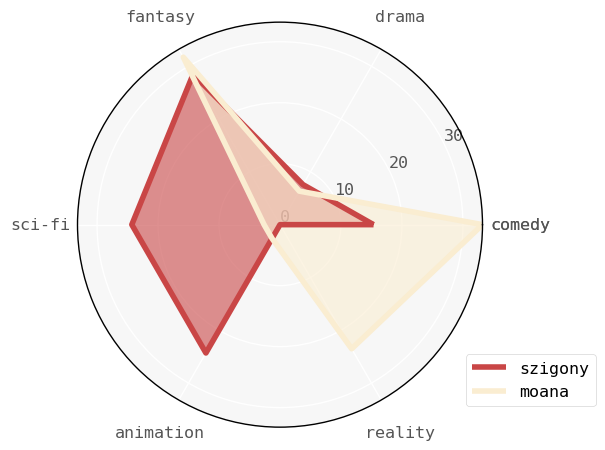

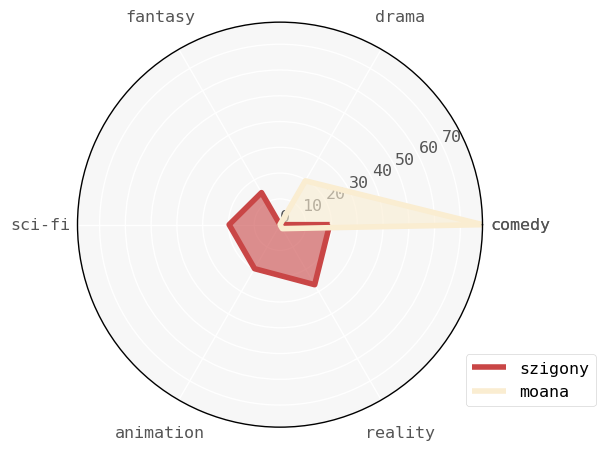

In [609]:
for radar_df in [merged_df, merged_pre, merged_post]:
    create_radar_chart(create_radar_chart_data(radar_df))